# Bernoulli Naive Bayes for 20newsgroup dataset

The Naive bayes model works better for four feature (used as an example to build the model) by giving around 94% accuracy. But when we incude all the features the accuracy drops to 78.7%.
And as the sparse matrix shows, the words are not very uniformly distributed. Hence removing a few features can assist the model. This is implemented our next NB model for 20newsgroups data

In [1]:
#import required libraries
import pandas as pd 
import numpy as np 
from collections import defaultdict
import re
%matplotlib inline                                 
import matplotlib.pyplot as plt 
from IPython.core.debugger import set_trace  
import scipy.sparse as sparse
import seaborn as sns

np.random.seed(1234)

# Data preprocessing and data exploration

In [2]:
#import data
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'))

In [3]:
newsgroups_test = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'))
print('Number of train files:\n', len(newsgroups_train.data)) # number of files
print('Number of test files:\n', len(newsgroups_test.data))

Number of train files:
 11314
Number of test files:
 7532


In [4]:
# Labels 
y_train = newsgroups_train.target
print('y_train dimensions:\n', y_train.shape, '\nFirst elements:\n', y_train[:5])

y_test = newsgroups_test.target
print('y_test dimensions:\n', y_test.shape, '\nFirst elements:\n', y_test[:5])

y_train dimensions:
 (11314,) 
First elements:
 [ 7  4  4  1 14]
y_test dimensions:
 (7532,) 
First elements:
 [ 7  5  0 17 19]


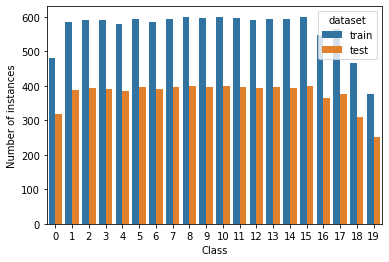

In [6]:
#plot class distribution
y_train_df = pd.DataFrame(data=y_train, columns=['class'])
y_test_df = pd.DataFrame(data=y_test, columns=['class'])
y_train_df['dataset'] = 'train'
y_test_df['dataset'] = 'test'
y_df = pd.concat([y_train_df, y_test_df], axis=0)
ax = sns.countplot(x='class', hue ='dataset', data=y_df)
ax.set(xlabel='Class', ylabel='Number of instances')
#plt.savefig(path+'newsgroups_labels.png')
plt.show()


Text vectorzation

In [7]:
#basic vectorization using stop words
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(binary=True, stop_words=['in','of','at','a','the'])
x_train = count_vect.fit_transform(newsgroups_train.data)
print(x_train.shape)
x_test = count_vect.transform(newsgroups_test.data)
print(x_test.shape)

(11314, 101627)
(7532, 101627)


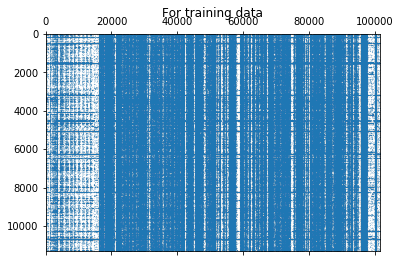

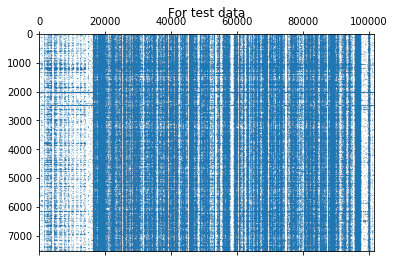

In [8]:
#visualise the sparse matrix
plt.spy(x_train, markersize=0.05, aspect='auto')
plt.title("For training data")
plt.show()
plt.spy(x_test, markersize=0.05, aspect='auto')
plt.title("For test data")
plt.show()

In [9]:
#Vectorization by removing bigrams
count_vect_bigrams = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words=['in','of','at','a','the'])
x_train_bigrams = count_vect_bigrams.fit_transform(newsgroups_train.data)
print(x_train_bigrams.shape)
x_test_bigrams = count_vect_bigrams.transform(newsgroups_test.data)
print(x_test_bigrams.shape)

(11314, 999239)
(7532, 999239)


In [10]:
#Vectorization using word frequency
freq_vect = CountVectorizer(stop_words=['in','of','at','a','the'])
x_train_freq = freq_vect.fit_transform(newsgroups_train.data)
print(x_train_freq.shape)
x_test_freq = freq_vect.transform(newsgroups_test.data)
print(x_test_freq.shape)

(11314, 101627)
(7532, 101627)


# Self implemented Naive Bayes

In [2]:
def preprocess_string(str_arg):   
    cleaned_str=re.sub('[^a-z\s]+',' ',str_arg,flags=re.IGNORECASE) #every char except alphabets is replaced
    cleaned_str=re.sub('(\s+)',' ',cleaned_str) #multiple spaces are replaced by single space
    cleaned_str=cleaned_str.lower() #converting the cleaned string to lower case  
    return cleaned_str # returning the preprocessed string 


In [3]:
class NaiveBayes:
    
    def __init__(self,unique_classes):
        self.classes=unique_classes # Constructor is sinply passed with unique number of classes of the training set
        

    def addToBow(self,example,dict_index):
        #Create a bag of word: vocabulary
        if isinstance(example,np.ndarray): example=example[0]
        for token_word in example.split(): #for every word in preprocessed example
            self.bow_dicts[dict_index][token_word]+=1 #increment in its count
            
    def train(self,dataset,labels):
        self.examples=dataset
        self.labels=labels
        self.bow_dicts=np.array([defaultdict(lambda:0) for index in range(self.classes.shape[0])])       
        #only convert to numpy arrays if initially not passed as numpy arrays - else its a useless recomputation
        if not isinstance(self.examples,np.ndarray): self.examples=np.array(self.examples)
        if not isinstance(self.labels,np.ndarray): self.labels=np.array(self.labels)
            
        #constructing BoW for each category
        for cat_index,cat in enumerate(self.classes):
            all_cat_examples=self.examples[self.labels==cat] #filter all examples of category == cat
            #get examples preprocessed
            cleaned_examples=[preprocess_string(cat_example) for cat_example in all_cat_examples]
            cleaned_examples=pd.DataFrame(data=cleaned_examples)
            #now costruct BoW of this particular category
            np.apply_along_axis(self.addToBow,1,cleaned_examples,cat_index)
      
        prob_classes=np.empty(self.classes.shape[0])
        all_words=[]
        cat_word_counts=np.empty(self.classes.shape[0])
        for cat_index,cat in enumerate(self.classes):   
            #Calculating prior probability p(c) for each class
            prob_classes[cat_index]=np.sum(self.labels==cat)/float(self.labels.shape[0]) 
            #Calculating total counts of all the words of each class 
            count=list(self.bow_dicts[cat_index].values())
            cat_word_counts[cat_index]=np.sum(np.array(list(self.bow_dicts[cat_index].values())))+1 # |v| is remaining to be added
            #get all words of this category                                
            all_words+=self.bow_dicts[cat_index].keys()                                                    
        
        #combine all words of every category & make them unique to get vocabulary -V- of entire training set
        self.vocab=np.unique(np.array(all_words))
        self.vocab_length=self.vocab.shape[0]                          
        #computing denominator value                                      
        denoms=np.array([cat_word_counts[cat_index]+self.vocab_length+1 for cat_index,cat in enumerate(self.classes)])
        self.cats_info=[(self.bow_dicts[cat_index],prob_classes[cat_index],denoms[cat_index]) for cat_index,cat in enumerate(self.classes)]                               
        self.cats_info=np.array(self.cats_info)                                 
                                              
                                              
    def getExampleProb(self,test_example):                                                                             
        likelihood_prob=np.zeros(self.classes.shape[0]) #to store probability w.r.t each class
        #finding probability w.r.t each class of the given test example
        for cat_index,cat in enumerate(self.classes):        
            for test_token in test_example.split(): #split the test example and get p of each test word                               
                #This loop computes : for each word w [ count(w|c)+1 ] / [ count(c) + |V| + 1 ]                               
                
                #get total count of this test token from it's respective training dict to get numerator value                           
                test_token_counts=self.cats_info[cat_index][0].get(test_token,0)+1
                #now get likelihood of this test_token word                              
                test_token_prob=test_token_counts/float(self.cats_info[cat_index][2])                              
                #Use log to prevent number underflow!
                likelihood_prob[cat_index]+=np.log(test_token_prob)                  
        # we have likelihood estimate of the given example against every class but we need posterior probility
        post_prob=np.empty(self.classes.shape[0])
        for cat_index,cat in enumerate(self.classes):
            post_prob[cat_index]=likelihood_prob[cat_index]+np.log(self.cats_info[cat_index][1])                                  
        return post_prob
    
   
    def test(self,test_set):
        predictions=[] #to store prediction of each test example
        for example in test_set:                     
            #preprocess the test example the same way we did for training set exampels                                  
            cleaned_example=preprocess_string(example) 
            #simply get the posterior probability of every example                                  
            post_prob=self.getExampleProb(cleaned_example) #get prob of this example for both classes
            #simply pick the max value and map against self.classes!
            predictions.append(self.classes[np.argmax(post_prob)])
        return np.array(predictions) 


In [4]:
from sklearn.datasets import fetch_20newsgroups

#categories=['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med'] 
categories=['alt.atheism','comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x','misc.forsale','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey','sci.crypt','sci.electronics','sci.med','sci.space','soc.religion.christian','talk.politics.guns','talk.politics.mideast','talk.politics.misc','talk.religion.misc']
newsgroups_train=fetch_20newsgroups(subset='train',categories=categories)
train_data=newsgroups_train.data #getting all trainign examples
train_labels=newsgroups_train.target #getting training labels
print ("Total Number of Training Examples: ",len(train_data)) # Outputs -> Total Number of Training Examples:  2257 (for four cat)
print ("Total Number of Training Labels: ",len(train_labels)) # Outputs -> Total Number of Training Labels:  2257 (for four cat)


Total Number of Training Examples:  11314
Total Number of Training Labels:  11314


In [5]:
nb=NaiveBayes(np.unique(train_labels)) #instantiate a NB class object
print ("---------------- Training In Progress --------------------")
 
nb.train(train_data,train_labels) #start tarining by calling the train function
print ('----------------- Training Completed ---------------------')

---------------- Training In Progress --------------------
----------------- Training Completed ---------------------


In [6]:
newsgroups_test=fetch_20newsgroups(subset='test',categories=categories) #loading test data
test_data=newsgroups_test.data #get test set examples
test_labels=newsgroups_test.target #get test set labels

print ("Number of Test Examples: ",len(test_data)) # Output : Number of Test Examples:  1502(for four cat)
print ("Number of Test Labels: ",len(test_labels)) # Output : Number of Test Labels:  1502(for four cat)

Number of Test Examples:  7532
Number of Test Labels:  7532


In [7]:
pclasses=nb.test(test_data) #get predcitions for test set

#check how many predcitions actually match original test labels
test_acc=np.sum(pclasses==test_labels)/float(test_labels.shape[0]) 

print ("Test Set Examples: ",test_labels.shape[0]) # Outputs : Test Set Examples:  1502 (for four cat)
print ("Test Set Accuracy: ",test_acc*100,"%") # Outputs : Test Set Accuracy:  93.8748335553 % (for four cat)

Test Set Examples:  7532
Test Set Accuracy:  78.71747211895911 %
